$\textbf{TD(0) tailored for the reset application}$

The pseudo-code for TD(0) tailored for the reset application can be found in Algorithm 1.

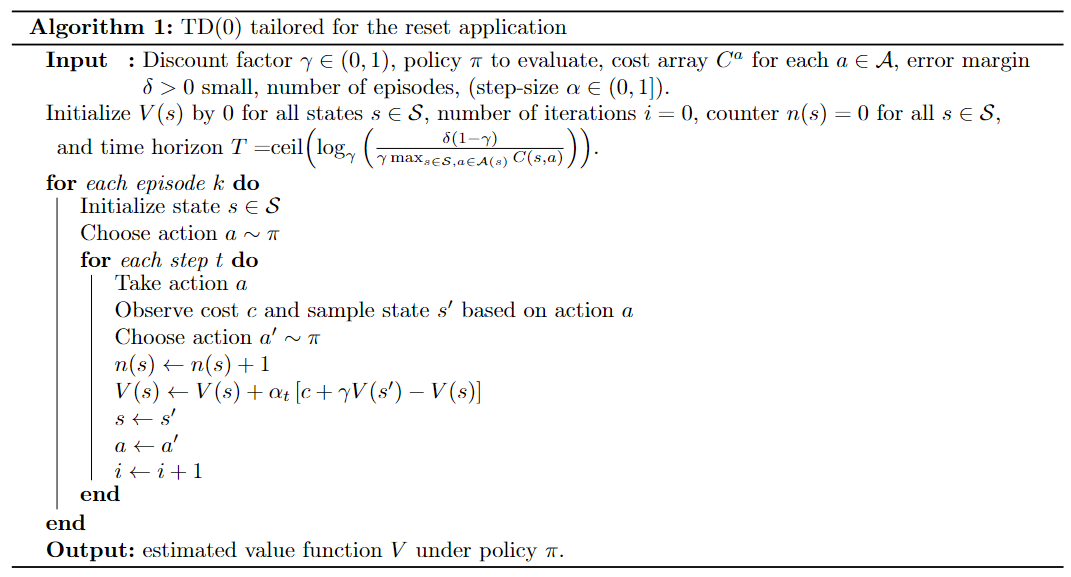

The implementation of this algorithm can be found in the code below.

In [1]:

import numpy as np
import time
import matplotlib.pyplot as plt



def TD_zero(alpha, gamma,P,C_0,C_1, pi_s, nrepisodes):
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
    alpha_type = alpha

    
    # size of the state space-1
    N=np.size(P,1)-1
    
    # state space S
    S=np.arange(N+1)
    
    # Initialize Q-values by 0, here the rows correspond to the action and columns to the state
    # i.e., Q is of the form Q[s,a]
    Q=np.zeros([N+1,2])
    
    # setting the Q value for "illegal" actions to infinity
    Q[0,1]=float("inf")
    Q[N,0]=float("inf")
    
    # nr of iterations
    it=0
    
    # preselect time-horizon T
    delta=0.000001 # error margin
    C_0[N]=0 # setting cost "illegal" actions to zero
    C_1[0]=0 # setting cost "illegal" actions to zero
    C=np.array([C_0,C_1])   
    T=round(np.log((delta*(1-gamma))/(C.max()))/np.log(gamma)-1) # time-horizon T
    
    # Q[s,a,iteration number]: array to keep track of the Q-values per iteration
    Q_it=np.zeros([N+1,2,(nrepisodes-1)*T])
    
    # n_it[s,a] denotes the number of times (s,a) is visited
    n_it=np.zeros([N+1,2])
    
    # array to keep track of the actions, costs, states, and step-size at each iteration
    a_it = np.zeros((nrepisodes-1)*T)
    r_it = np.zeros((nrepisodes-1)*T)
    s_it = np.zeros((nrepisodes-1)*T)
    alpha_it = np.zeros([N+1,2,(nrepisodes-1)*T])
    
    # loop for each episode
    for e in range(1,nrepisodes):
        
        # randomly selecting and storing initial state
        state =  np.random.randint(0, N+1)
        
        ## select and store an action a_0
        action = pi_s[state]

        # making sure the randomly chosen action is allowed for the state
        if state==0:
            action=0 
        elif state==N:
            action=1
            
        # loop for t=0,1,...,T-1
        for t in range(T): # when i do it like this it stays stuck in the first episode..

            # taking action A_t 
            # observing and storing the next reward as R_{t+1}
            # and sampling the next state S_{t+1} according to P   
            if action==1:
                next_state = 0
                reward = C_1[state] 
            elif action==0:
                next_state = np.random.choice(S,p=P[state,:])
                reward = C_0[state]
            
            # keeping track of the states, actions, and costs for each iteration
            s_it[it]=state
            a_it[it]=action
            r_it[it]=reward
            
            # the next action according to the policy for the next state
            next_action = pi_s[next_state]

            # making sure the randomly chosen action is allowed for the state
            if next_state==0:
                next_action=0 
            elif next_state==N:
                next_action=1
             
            # incrementing the nr of visits to (s,a) by 1    
            n_it[state,action]+=1    
            
            # in case we want to use an alpha depending on the iteration nr:
            if alpha_type == 10:
                alpha=1/np.log(it+3)  # +3 to make sure alpha<=1
                
            if alpha_type == 40:
                alpha=1/np.log(n_it[state,action]+2)
            
            if alpha_type == 20:
                alpha=1/n_it[state,action]
                
            if alpha_type == 30:
                alpha=1/(it+1)
            
            alpha_it[state,action,it]=alpha
            
            # updating the Q-values
            Q[state,action]+=alpha*(reward+ gamma*Q[next_state,next_action]-Q[state,action])
            
            # storing the Q(s,a)-update per iteration
            Q_it[state,action,it]=Q[state,action]
            
            # increment the number of iterations by 1
            it+=1   
            
            # s <- s'
            state = next_state
            
            # a <- a'
            action = next_action
            
    # the value under policy pi
    V_pi = np.array([Q[s,pi_s[s]] for s in range(0,N+1)])
    
    return Q, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, V_pi


Initializing the algorithm's parameters:

In [3]:
# discount factor
gamma=0.3

# step-size alpha:
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
alpha=20

# nr of episodes
nrepisodes = 2000

# number of states - 1
N=3


# policy to evaluate
pi_s = np.zeros(N+1,dtype=int)
pi_s[N]=1


Initializing the probability transition matrix (choose one of the three):

In [ ]:
# P_A
P = np.diag(np.ones(N),1)
P[N,0]=1


In [4]:
# P_B
P = np.diag(1/2*np.ones(N),1)+np.diag(1/2*np.ones(N),-1)
P[-1,-2]=1
P[0,1]=1


In [ ]:
# P_C
P = 1/4*np.ones([N+1,N+1])


Initializing the cost realization (choose one of the three):

In [5]:
# Realization 1

# Cost for action = 0
C_0=np.zeros(N+1)

# Cost for action = 1
C_1=np.arange(N+1,dtype=float)
C_1[N]=2*N


In [ ]:
# Realization 2

# Cost for action = 0
C_0=np.arange(N+1,dtype=float)+1 

# Cost for action = 1
K=2
C_1=K*C_0


In [ ]:
# Realization 3

# Cost for action = 0
C_0=1/np.arange(N+1,0,-1,dtype=float)

# Cost for action = 1
C_1=10**np.arange(N+1,dtype=float)


$\textit{Example}:$ cost realization 1 with transition matrix $\mathcal{P}_B$ for $\gamma=0.3$ and $N=3$.

In [6]:
Q, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, V_pi = TD_zero(alpha, gamma,P,C_0,C_1, pi_s, nrepisodes)

print("Estimated value: \n",V_pi)

Estimated value: 
 [0.04014338 0.13890658 0.91257972 6.01136324]
